# Model Segmentation

A significantly higher/lower level of risk is identified for a sub-segemnt of the protfolio. It must be decided whether the this sub-segment is 
- calibrated separately
- or also requires a separate risk ranking/ score card.

It must be analyzed whether given model's risk differentiation performs equally or sufficiently well on the subsegment as it does on the overall portfolio.

An easy yet very insightful analysis can be performed by building a gradient boosting or random forest model. These models are ensembles of decision trees. Hence, they essentially work with subsegmentation. Shapley values can be calulated very efficiently for these models and can give insight into the variable importance within subsegemnts. If the variable importance within a subsegment is very different from that of the overall model, it suggests that the sub-segemnt requires separate risk differentiation.

The following is an example analysis using loan default data available online https://www.kaggle.com/datasets/yasserh/loan-default-dataset

In [14]:
# Libraries
import pandas as pd # Dataframes
import numpy as np
import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Visualization
import h2o
from h2o.estimators import H2OGradientBoostingEstimator

In [ ]:
try:
    h2o.cluster().shutdown()
except:
    pass
finally:
    h2o.init(ip='127.0.0.1', port=54325, min_mem_size='16G')

In [16]:
# Read in data
# data is taken from https://www.kaggle.com/datasets/yasserh/loan-default-dataset
df = pd.read_csv("Loan_Default.csv")

In [ ]:
df.shape

In [18]:
# First 100 entries
head100 = df.head(100)

# Convert all column names to lowercase
df.columns=df.columns.str.lower()

# Make ID string type
df['id'] = df['id'].astype(str)

In [ ]:
# Datatypes
df.columns

In [ ]:
import missingno as msno # Visualizing null values

nas = df.isna().sum()
print(nas)

# Visualizing Null values (image)
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

In [ ]:
# Drop year since all entries are 2019
df.drop(columns=['year','rate_of_interest','interest_rate_spread','upfront_charges'], inplace=True)

df = df.dropna()
df.shape

In [ ]:
df.status.sum()

In [23]:
# Getting dataframes by datatype
dtypes = pd.DataFrame(df.dtypes).reset_index()

cat_vars = []
num_vars = []
for i, l in zip(dtypes['index'], dtypes[0]):
    if l == 'object':
        cat_vars.append(i)
    else:
        num_vars.append(i)

In [ ]:
cat_vars

In [ ]:
num_vars

In [27]:
X_vars = num_vars + cat_vars

In [26]:
df_h2o = h2o.H2OFrame(df)
train, valid = df_h2o.split_frame(ratios=[.8], seed=1234)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [34]:
# ====================================================================
# Splitting Data
# ====================================================================
## pick a response for the supervised problem
response = "status"

## the response variable is an integer, we will turn it into a categorical/factor for binary classification  
# train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

test_h2o = h2o.H2OFrame(test_set)
test_h2o[response] = test_h2o[response].asfactor()

train_h2o = h2o.H2OFrame(train_set)
train_h2o[response] = train_h2o[response].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Build Gradient Boosting Model

In [37]:
gbm = H2OGradientBoostingEstimator()
gbm.train(x=X_vars, y=response, training_frame=train_h2o)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1689580115729_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22077.0,5.0,5.0,5.0,17.0,32.0,30.46




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.09535318615276002
RMSE: 0.3087931122171607
LogLoss: 0.326312874410814
Mean Per-Class Error: 0.28602661983762784
AUC: 0.820297572742781
AUCPR: 0.617531269688364
Gini: 0.6405951454855621

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2739522563017029: 


,,0,1,Error,Rate
0,0,76272.0,4451.0,0.0551,(4451.0/80723.0)
1,1,8114.0,7583.0,0.5169,(8114.0/15697.0)
2,Total,84386.0,12034.0,0.1303,(12565.0/96420.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.273952,0.546897,211.0
1,max f2,0.127636,0.606649,306.0
2,max f0point5,0.437007,0.650330,151.0
3,max accuracy,0.417481,0.882555,157.0
4,max precision,0.992145,1.000000,0.0
5,max recall,0.042084,1.000000,396.0
6,max specificity,0.992145,1.000000,0.0
7,max absolute_mcc,0.346327,0.496913,180.0
8,max min_per_class_accuracy,0.140223,0.736506,295.0
9,max mean_per_class_accuracy,0.161504,0.741772,278.0



Gains/Lift Table: Avg response rate: 16.28 %, avg score: 16.29 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010008,0.912516,6.104383,6.104383,0.993782,0.951547,0.993782,0.951547,0.061094,0.061094,510.438284,510.438284,0.061020
1,2,0.020017,0.822607,6.098017,6.101200,0.992746,0.870563,0.993264,0.911055,0.061031,0.122125,509.801748,510.120016,0.121964
2,3,0.030004,0.725420,5.670560,5.957852,0.923157,0.772548,0.969927,0.864950,0.056635,0.178760,467.055990,495.785188,0.177683
3,4,0.040002,0.653315,4.995621,5.717357,0.813278,0.689117,0.930775,0.821003,0.049946,0.228706,399.562117,471.735657,0.225399
4,5,0.050000,0.593928,4.606931,5.495318,0.750000,0.621224,0.894628,0.781055,0.046060,0.274766,360.693126,449.531758,0.268473
5,6,0.100000,0.320468,3.232465,4.363891,0.526239,0.433506,0.710434,0.607280,0.161623,0.436389,223.246480,336.389119,0.401802
6,7,0.150000,0.239264,1.723896,3.483893,0.280647,0.274781,0.567171,0.496447,0.086195,0.522584,72.389629,248.389289,0.445035
7,8,0.200031,0.198084,1.377750,2.957111,0.224295,0.216542,0.481412,0.426438,0.068930,0.591514,37.775003,195.711147,0.467609
8,9,0.300000,0.154027,1.122220,2.345671,0.182695,0.173661,0.381871,0.342205,0.112187,0.703701,12.221959,134.567115,0.482203
9,10,0.400031,0.120894,0.782072,1.954680,0.127320,0.136758,0.318218,0.290832,0.078232,0.781933,-21.792824,95.468009,0.456164




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2023-07-17 10:02:07,0.059 sec,0.0,0.369181,0.444281,0.500000,0.162798,1.000000,0.837202
1,,2023-07-17 10:02:07,0.402 sec,1.0,0.362199,0.427827,0.706108,0.452388,5.921265,0.205186
2,,2023-07-17 10:02:07,0.583 sec,2.0,0.356949,0.417504,0.720016,0.461974,5.949586,0.233717
3,,2023-07-17 10:02:08,0.790 sec,3.0,0.352514,0.409194,0.730113,0.479452,5.951965,0.231612
4,,2023-07-17 10:02:08,1.011 sec,4.0,0.348861,0.402681,0.730625,0.481853,5.964713,0.176727
5,,2023-07-17 10:02:08,1.194 sec,5.0,0.345484,0.396593,0.739925,0.495543,5.958552,0.176260
6,,2023-07-17 10:02:08,1.327 sec,6.0,0.342423,0.390799,0.759237,0.515314,5.992604,0.222267
7,,2023-07-17 10:02:08,1.421 sec,7.0,0.339724,0.386100,0.763352,0.519659,5.986988,0.161533
8,,2023-07-17 10:02:08,1.480 sec,8.0,0.337393,0.382022,0.764860,0.523867,6.053460,0.138052
9,,2023-07-17 10:02:08,1.542 sec,9.0,0.335159,0.377678,0.770138,0.532316,6.078987,0.157447



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,dtir1,3965.694092,1.000000,0.200759
1,ltv,2581.673096,0.651002,0.130695
2,loan_type,2452.310791,0.618381,0.124146
3,income,1965.724609,0.495682,0.099513
4,lump_sum_payment,1749.988037,0.441282,0.088591
5,loan_purpose,1144.884399,0.288697,0.057959
6,neg_ammortization,1053.502319,0.265654,0.053332
7,loan_amount,1003.596313,0.253070,0.050806
8,credit_worthiness,969.185181,0.244392,0.049064
9,submission_of_application,867.297302,0.218700,0.043906



See the whole table with table.as_data_frame()


## Produce Shapley Summary PLot on full training sample

- Shapley Values come from cooperative game theory and quantify the fair pay-out for each player 𝑖 considering all possible coalitions
- Shapley Values (applied to machine learning) explain the prediction for any instance 𝑥_𝑺 as a sum of marginal contributions from each feature 𝒊.
- The absolute sum of Shapley Values (over all predictions) of a feature is a particularly good measure of feature importance.

In the summary plot:
- Features are sorted by their feature importance (global impact)
- Dots represent the Shapley Values and are plotted horizontally, stacking vertically when they run out of space (violin plot w/o smoothing)
- Each dot is colored by the value of that feature, from low (blue) to high (red). 

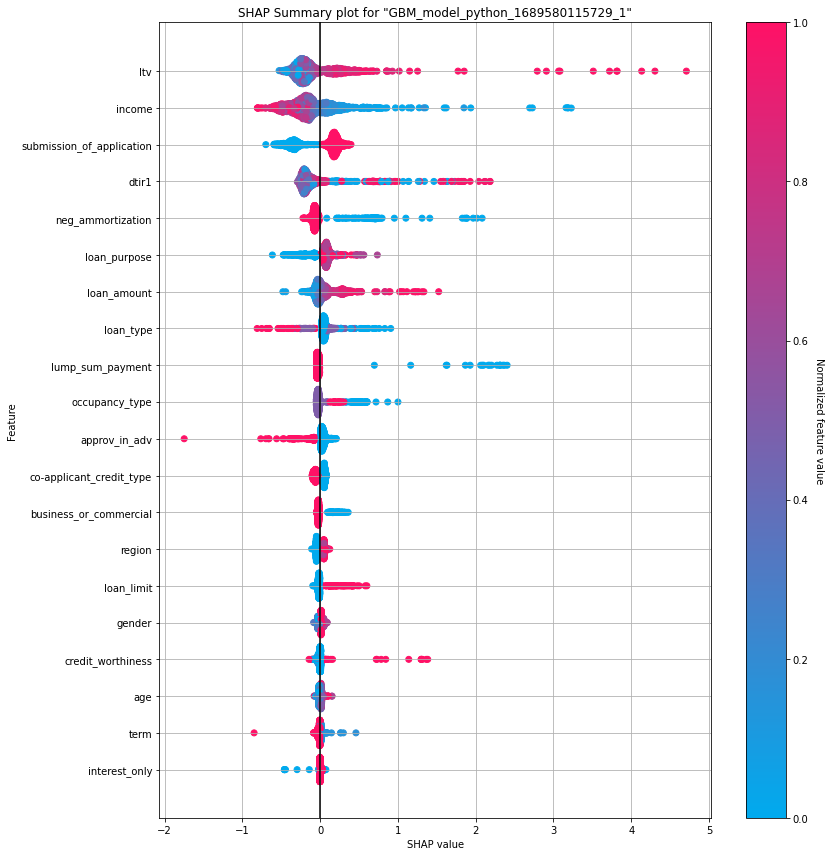

In [38]:
shap_plot_train = gbm.shap_summary_plot(train_h2o)

## Produce Shapley Summary PLot for sub-segments

We see that "submission_of_application" is a binary variable which is fairly important. Let's see what the risk differentiation looks like on the subsegments where 
- "submission_of_application"=="not_inst"
- "submission_of_application"=="to_inst"

We that "submission_of_application" not only leads to a shift in the level of risk but that the importance of other features for risk differentiation is different in the two subsegments,

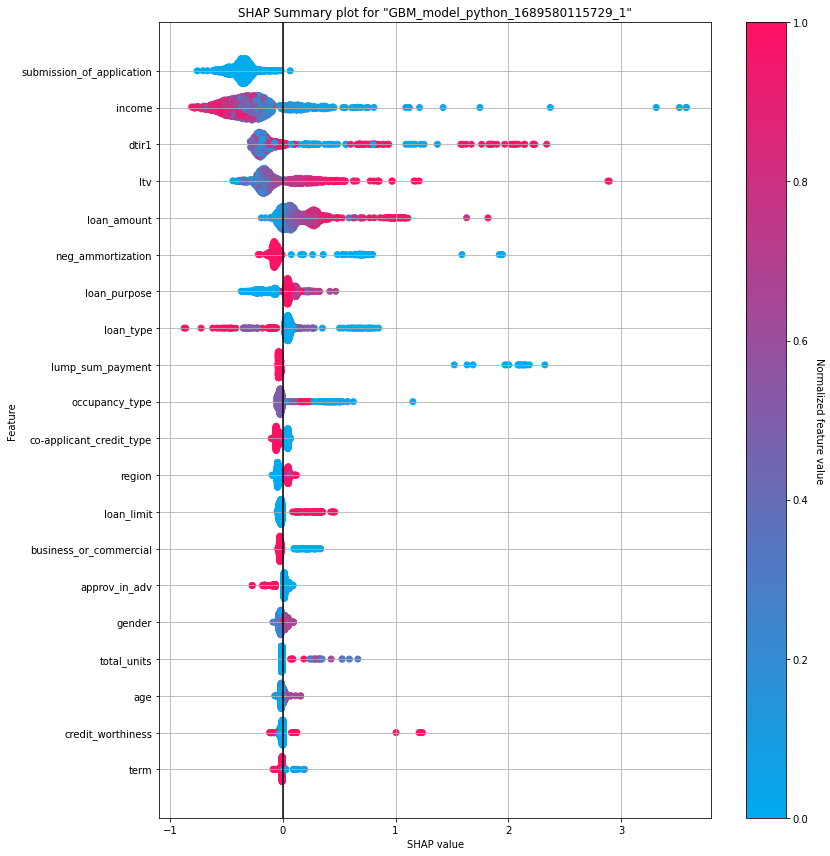

In [41]:
gbm.shap_summary_plot(train_h2o[train_h2o["submission_of_application"]=="not_inst"])

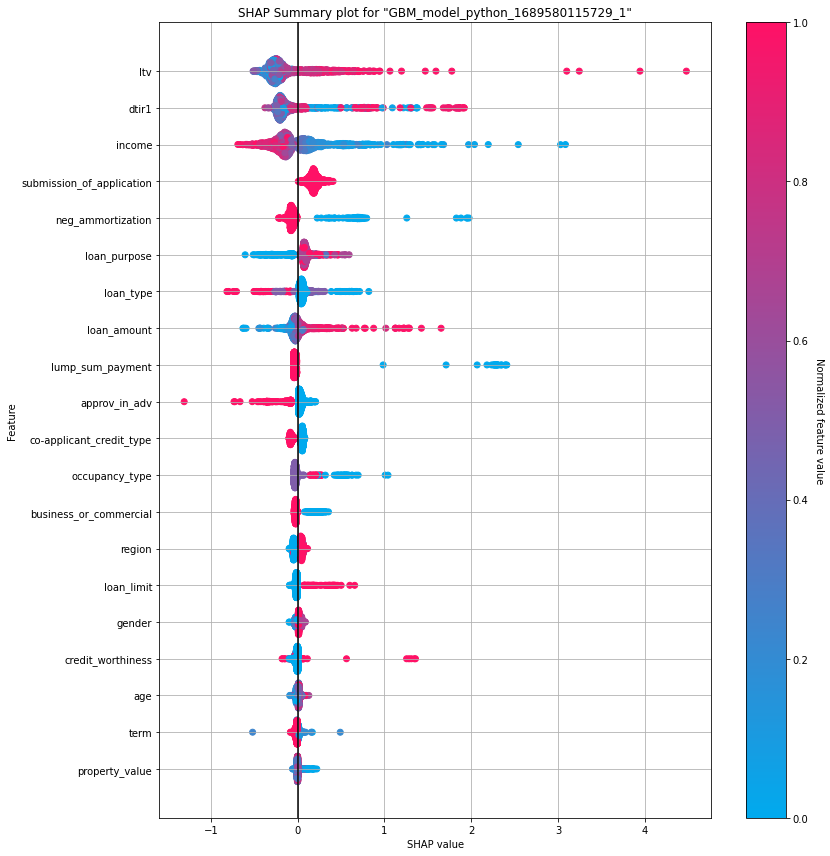

In [44]:
gbm.shap_summary_plot(train_h2o[train_h2o["submission_of_application"]=="to_inst"])